<a href="https://colab.research.google.com/github/sankalpachowdhury/Galaxy-Classification-using-CNN/blob/master/24_08_20_Model2_Galaxy_classification_Early_St_%26_MCh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing necessary Python modules 

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras 
import matplotlib.pyplot as plt
%matplotlib inline
import os, random, shutil
from keras_preprocessing import image

#Drive mount and data formatting

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Unzipping the zip file to load images.
The 'images_training_rev1.zip' contains 61578 different types of images.

In [4]:
import zipfile
with zipfile.ZipFile('/content/drive/My Drive/Astronomical /Galaxy_classification_project/images_training_rev1.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

Creating dataframe to load data from csv file for classification.

In [5]:
df = pd.read_csv('/content/drive/My Drive/Astronomical /Galaxy_classification_project/training_solutions_rev1.csv')
print('Galaxy classification dataframe: \n',df.head)
print('\nDataframe shape: ',df.shape)

Galaxy classification dataframe: 
 <bound method NDFrame.head of        GalaxyID  Class1.1  Class1.2  ...  Class11.4  Class11.5  Class11.6
0        100008  0.383147  0.616853  ...   0.000000        0.0   0.325512
1        100023  0.327001  0.663777  ...   0.000000        0.0   0.000000
2        100053  0.765717  0.177352  ...   0.000000        0.0   0.000000
3        100078  0.693377  0.238564  ...   0.000000        0.0   0.000000
4        100090  0.933839  0.000000  ...   0.000000        0.0   0.000000
...         ...       ...       ...  ...        ...        ...        ...
61573    999948  0.510379  0.489621  ...   0.000000        0.0   0.226257
61574    999950  0.901216  0.098784  ...   0.000000        0.0   0.000000
61575    999958  0.202841  0.777376  ...   0.000000        0.0   0.072296
61576    999964  0.091000  0.909000  ...   0.023065        0.0   0.045334
61577    999967  0.767000  0.140000  ...   0.000000        0.0   0.023380

[61578 rows x 38 columns]>

Dataframe shape:  

# Decision tree architecture
**Decision Tree based on questions**

Q1. Is the object a smooth galaxy, a galaxy with features/disk or a star? 3 responses

Q2. Is it edge-on? 2 responses

Q3. Is there a bar? 2 responses

Q4. Is there a spiral pattern? 2 responses

Q5. How prominent is the central bulge? 4 responses

Q6. Is there anything "odd" about the galaxy? 2 responses

Q7. How round is the smooth galaxy? 3 responses

Q8. What is the odd feature? 7 responses

Q9. What shape is the bulge in the edge-on galaxy? 3 responses

Q10. How tightly wound are the spiral arms? 3 responses

Q11. How many spiral arms are there? 6 responses

**Paths and the decision tree**

As a result, at each node or question, the total initial probability of a classification will sum to 1.0. Those initial probabilities are then weighted as follows.


**Weighting the responses**

The values of the morphology categories in the solution file are computed as follows. For the first set of responses (smooth, features/disk, star/artifact), the values in each category are simply the likelihood of the galaxy falling in each category. These values sum to 1.0. For each subsequent question, the probabilities are first computed (these will sum to 1.0) and then multiplied by the value which led to that new set of responses. 

Here is a simplified example: a galaxy had 80% of users identify it as smooth, 15% as having features/disk, and 5% as a star/artifact.

```
Class1.1 = 0.80

Class1.2 = 0.15

Class1.3 = 0.05
```
For the 80% of users that identified the galaxy as "smooth", they also recorded responses for the galaxy's relative roundness. These votes were for 50% completely round, 25% in-between, and 25% cigar-shaped. The values in the solution file are thus:
```
Class 7.1 = 0.80 * 0.50 = 0.40

Class 7.2 = 0.80 * 0.25 = 0.20

Class 7.3 = 0.80 * 0.25 = 0.20
```
The reason for this weighting is to emphasize that a good solution must get the high-level, large-scale morphology categories correct. The best solutions, though, will also have high levels of accuracy on the detailed solutions that are further down the decision tree.

# Daraframe segmentation using Decision tree
Based on the survey 38 different result categories stored in the dataframe, images are segregated into 3 main categories

**1. Elliptical,** 
**2. Lenticular,** 
**3. Spiral**

Based on the mentioned conditions 3 lists are created which stores the galaxy ids of the corresponding classes.



In [6]:
elliptical = df[(df['Class1.1']>0.8) & (df['Class7.1']>0.4)]['GalaxyID'].tolist()
lenticular = df[(df['Class1.1']>0.8) & (df['Class7.2']>0.4)]['GalaxyID'].tolist()
spiral = df[(df['Class1.2']>0.8) & (df['Class2.1']>0.4)]['GalaxyID'].tolist()
galaxy_names = ['elliptical','lenticular','spiral']
galaxy_ids = [elliptical, lenticular, spiral]

for serial, galaxy_class in enumerate(galaxy_ids):
  print('Total number of {0} examples: {1}'.format(galaxy_names[serial],len(galaxy_class)))

Total number of elliptical examples: 4555
Total number of lenticular examples: 3861
Total number of spiral examples: 3078


#Spliting Images based on labels

Based on the **'ids'** corresponding to different types of galaxies(**elliptical, lenticular,spiral**) the images are stored in different folders, for both train and validation dataset
```
Source path: /content/images_training_rev1 
Train_directory: /content/data/train
Validation_directory: /content/data/validation
```

In [11]:
source_path = '/content/images_training_rev1'
dest_path = '/content/data'

def _proc_images(src, dst, label, arr, percent):
    train_dir = os.path.join(dst, 'train')
    val_dir = os.path.join(dst, 'validation')
    
    train_dest = os.path.join(train_dir, label)
    val_dest   = os.path.join(val_dir, label)
    
    if not os.path.exists(train_dest):
        os.makedirs(train_dest)

    if not os.path.exists(val_dest):
        os.makedirs(val_dest)
    
    random.shuffle(arr)
    
    idx = int(len(arr)*percent)
    for i in arr[0:idx]:
        shutil.copyfile(os.path.join(src, str(i)+'.jpg'), os.path.join(train_dest, str(i)+'.jpg'))
    for i in arr[idx:]:
        shutil.copyfile(os.path.join(src, str(i)+'.jpg'), os.path.join(val_dest, str(i)+'.jpg'))
    
    print(label, 'done!')

for serial, galaxy_class in enumerate(galaxy_ids):
  _proc_images(source_path, dest_path, galaxy_names[serial], galaxy_class, 0.9)

elliptical done!
lenticular done!
spiral done!


<Figure size 1080x1080 with 0 Axes>

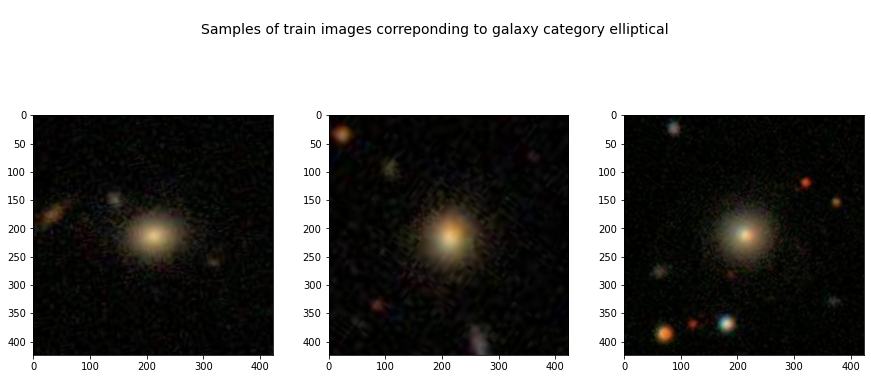

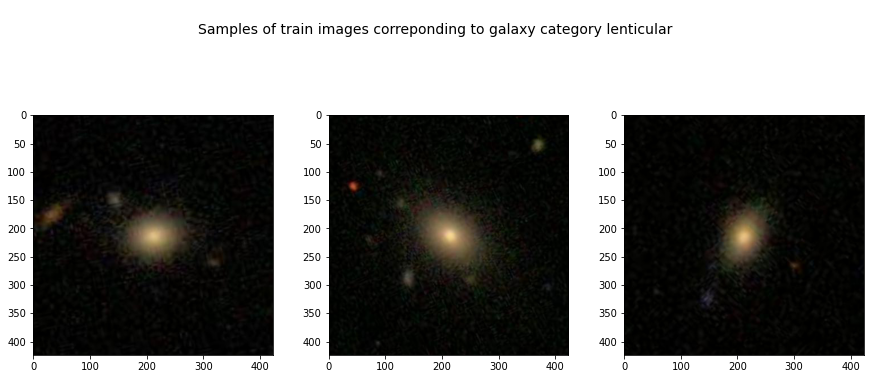

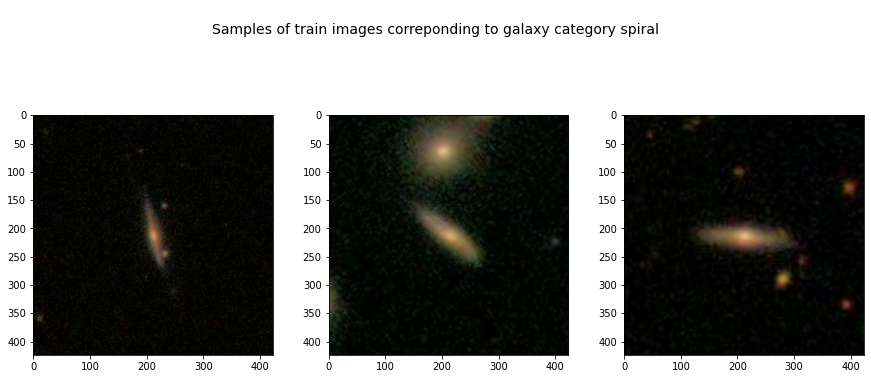

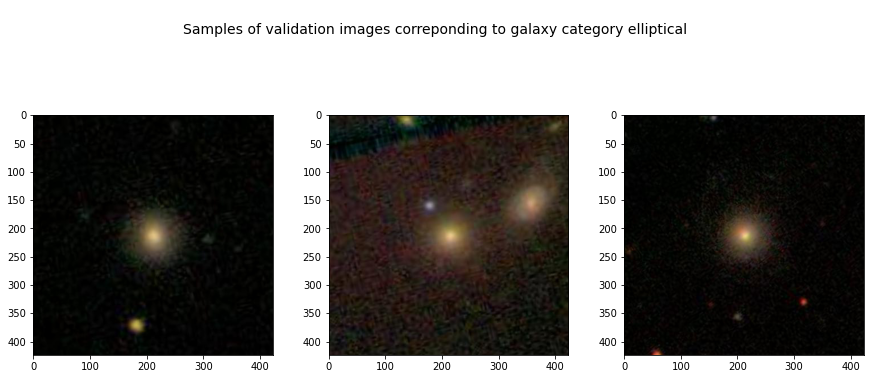

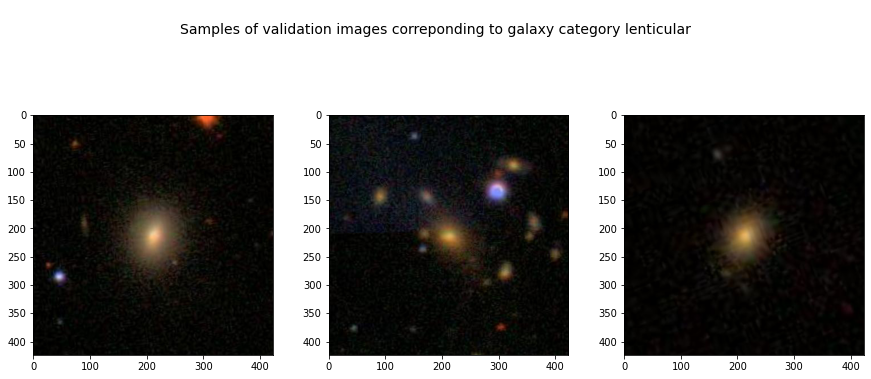

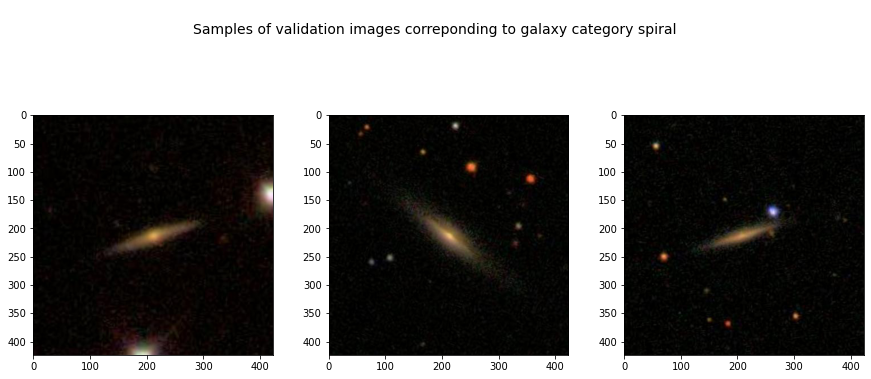

In [8]:
# Raw images before augmentation
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np

fig1=plt.figure(figsize=(15, 15))
for folder in ['train', 'validation']:
  for x,name in enumerate(galaxy_names):
    fig = plt.figure(figsize=(15, 15))
    for i,j in enumerate(os.listdir('/content/data/{0}/{1}'.format(folder, name))[0:3]): 
      fig.add_subplot(3, 3,i+1)    
      plt.imshow(img.imread(os.path.join('/content/data/{0}/{1}'.format(folder, name),j)))
      fig.suptitle('\nSamples of {0} images correponding to galaxy category {1}'.format(folder, name),fontsize = 14)
plt.show()  

#Data Augmentation


Install **Augmentor** package

In [9]:
!pip install Augmentor

**Augmentation techniques used**
---

>**1.   Rotation**
>* Rotate 90 degree(Probability = 0.5)
>* Rotate 270 degree(Probability = 0.5)

>**2.   Mirroring**
>* Horizontal flip(Probability = 0.5)
>* Vertical flip(Probability = 0.5)

>**3. Resizing**
* Augmented image size = (150,150) | (Probability = 0.5)

Target training samples after augmentation = 8000 for each class,
Target validation samples after augmentation = 1000 for each class






In [10]:
train_dir = '/content/Data1/Train/'
validation_dir = '/content/Data1/Test/'

import Augmentor

# Data augmentation for Training set
for serial, galaxy_class in enumerate(galaxy_ids):
  p = Augmentor.Pipeline(source_directory='/content/data/train/'+galaxy_names[serial],output_directory = train_dir+galaxy_names[serial])
  #Defining methods of Image Augmentation
  p.rotate90(probability=0.5)
  p.rotate270(probability=0.5)
  p.flip_left_right(probability=0.8)
  p.flip_top_bottom(probability=0.3)
  p.resize(probability=1.0, width=150, height=150)

  p.sample(8000)

# Data augmentation for Validation set
for serial, galaxy_class in enumerate(galaxy_ids):
  v = Augmentor.Pipeline(source_directory='/content/data/validation/'+galaxy_names[serial],output_directory = validation_dir+galaxy_names[serial])
  #Defining methods of Image Augmentation
  v.rotate90(probability=0.5)
  v.rotate270(probability=0.5)
  v.flip_left_right(probability=0.8)
  v.flip_top_bottom(probability=0.3)
  v.resize(probability=1.0, width=150, height=150)

  v.sample(1000)

Executing Pipeline:   0%|          | 0/8000 [00:00<?, ? Samples/s]

Initialised with 4099 image(s) found.
Output directory set to /content/Data1/Train/elliptical.

Processing <PIL.Image.Image image mode=RGB size=150x150 at 0x7FCCE90880B8>: 100%|██████████| 8000/8000 [00:56<00:00, 142.11 Samples/s]
Executing Pipeline:   0%|          | 0/8000 [00:00<?, ? Samples/s]

Initialised with 3474 image(s) found.
Output directory set to /content/Data1/Train/lenticular.

Processing <PIL.Image.Image image mode=RGB size=150x150 at 0x7FCCE92F73C8>: 100%|██████████| 8000/8000 [00:56<00:00, 141.43 Samples/s]
Executing Pipeline:   0%|          | 0/8000 [00:00<?, ? Samples/s]

Initialised with 2770 image(s) found.
Output directory set to /content/Data1/Train/spiral.

Processing <PIL.Image.Image image mode=RGB size=150x150 at 0x7FCCEF263CF8>: 100%|██████████| 8000/8000 [00:57<00:00, 140.10 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=150x150 at 0x7FCCF1ADB470>:   0%|          | 5/1000 [00:00<02:50,  5.84 Samples/s]

Initialised with 456 image(s) found.
Output directory set to /content/Data1/Test/elliptical.

Processing <PIL.Image.Image image mode=RGB size=150x150 at 0x7FCCF1A4ABA8>: 100%|██████████| 1000/1000 [00:07<00:00, 142.14 Samples/s]
Executing Pipeline:   0%|          | 0/1000 [00:00<?, ? Samples/s]

Initialised with 387 image(s) found.
Output directory set to /content/Data1/Test/lenticular.

Processing <PIL.Image.Image image mode=RGB size=150x150 at 0x7FCCE96A34A8>: 100%|██████████| 1000/1000 [00:06<00:00, 147.44 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=150x150 at 0x7FCCEFB08278>:   1%|          | 6/1000 [00:00<02:27,  6.73 Samples/s]

Initialised with 308 image(s) found.
Output directory set to /content/Data1/Test/spiral.

Processing <PIL.Image.Image image mode=RGB size=150x150 at 0x7FCCE96A92E8>: 100%|██████████| 1000/1000 [00:06<00:00, 143.89 Samples/s]


#Validating results of Augmentation
The scenario after Image Augmentation

In [12]:
# train_dir = '/content/Data1/Train'
# validation_dir = '/content/Data1/Test'

total_train = 0
for c in ['elliptical', 'lenticular', 'spiral']:
  total_train += len(os.listdir(os.path.join(train_dir, c)))
print('Total training images after augmentation:', total_train)

total_validation = 0
for c in ['elliptical', 'lenticular', 'spiral']:
  total_validation += len(os.listdir(os.path.join(validation_dir, c)))
print('Total validation images after augmentation:', total_validation)

Total training images after augmentation: 24000
Total validation images after augmentation: 3000


#Implementing **ImageDataGenerator**

Augmentation techniques passed

**Training:**
```
Techniques:
1. Normalization (binary image)
2. Translation (width_shift_range, height_shift_range)
3. Rotation
4. Zoom-in/out
5. Mirroring (horizontal_flip)
```
**Validation:**
```
Techniques:
 Normalization (binary image)
```
**Class mode:** Categorical


In [13]:
target = (150, 150) # target image size after Augmentation
batch_size = 32     # batch size (hyperparameter)

In [14]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                    rescale=1.0/255,
                    rotation_range=25,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.2)
validation_datagen  = tf.keras.preprocessing.image.ImageDataGenerator(
                    rescale=1.0/255,
                    #rotation_range=25,
                    #width_shift_range=.15,
                    #height_shift_range=.15,
                    #horizontal_flip=True,
                    #zoom_range=0.2
                    )
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=target,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    class_mode='categorical')
validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                         target_size=target,
                                                         batch_size=batch_size,
                                                         shuffle=True,
                                                         class_mode='categorical')

Found 24000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


<Figure size 1080x1080 with 0 Axes>

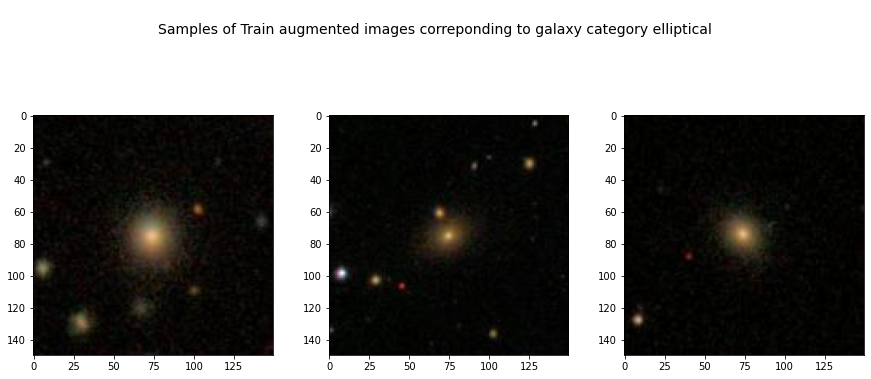

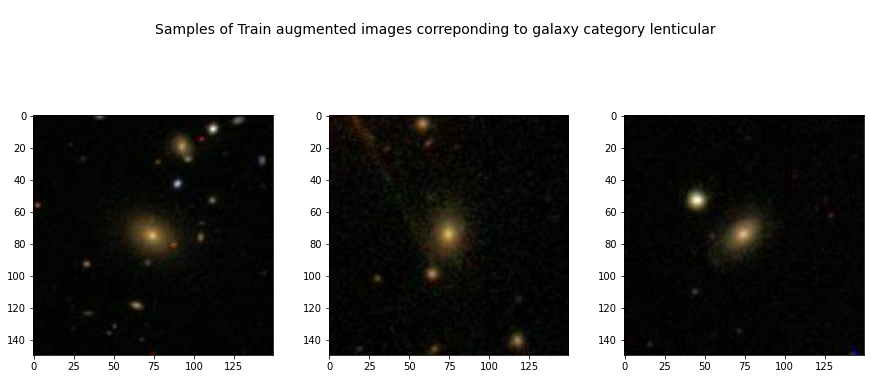

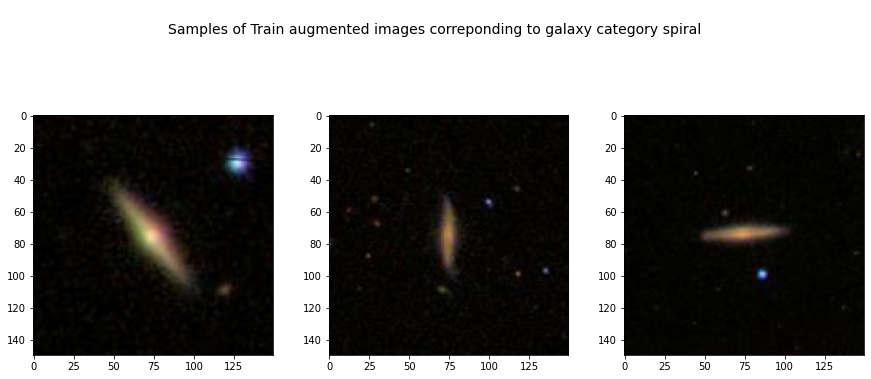

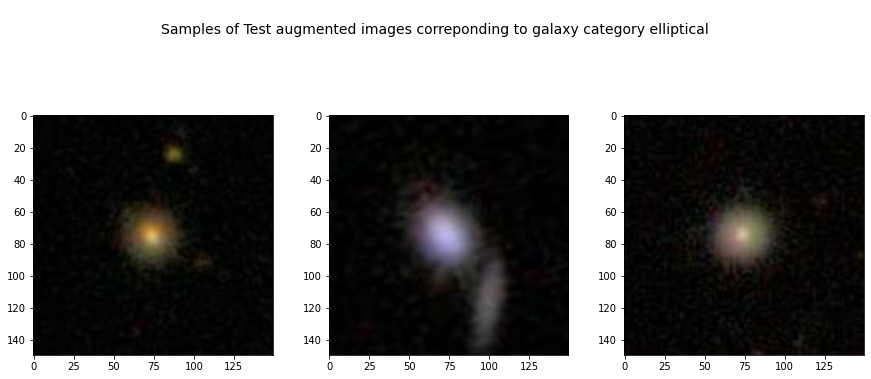

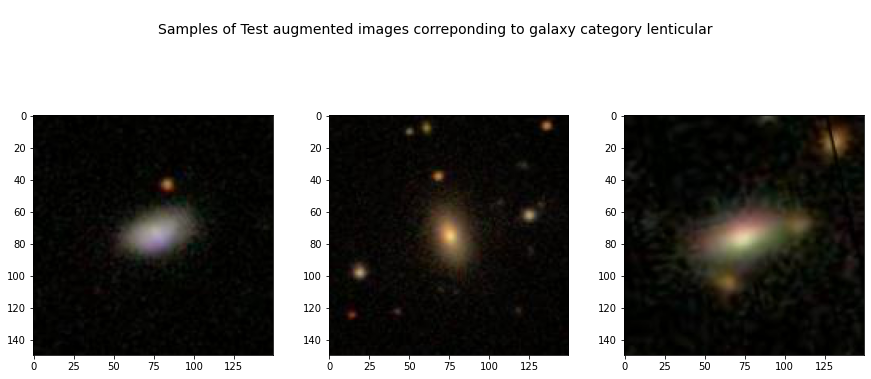

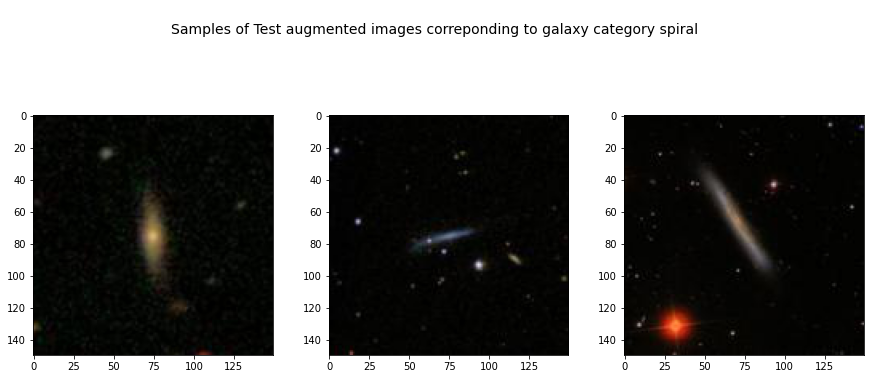

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np

fig1=plt.figure(figsize=(15, 15))
for folder in ['Train', 'Test']:
  for x,name in enumerate(galaxy_names):
    fig = plt.figure(figsize=(15, 15))
    for i,j in enumerate(os.listdir('/content/Data1/{0}/{1}'.format(folder, name))[0:3]): 
      fig.add_subplot(3, 3,i+1)    
      plt.imshow(img.imread(os.path.join('/content/Data1/{0}/{1}'.format(folder, name),j)))
      fig.suptitle('\nSamples of {0} augmented images correponding to galaxy category {1}'.format(folder, name),fontsize = 14)
plt.show() 

#**Building Classification Model using CNN**

---
*Model architecture (sequential)*
---
*  Filter shape: (3,3)

*  Pool shape(Constant): (2,2)

*  Input shape: (150,150)

*  Batch Normalization parameters(default):**

momentum = 0.99,
epsilon = 0.001,
renorm_momentum = 0.99

>**Layer1:** 
>
>a. Convolution: No. of filters: 32, 
>   Activation: RELU, 
>   Batch normalization
>
>b. Max-pool

>**Layer2:** 
>
>a. Convolution: No. of filters: 32, 
>   Activation: RELU, 
>   Batch normalization
>   
>b. Max-pool

>**Layer3:** 
>
>a. Convolution: No. of filters: 64, 
>   Activation: RELU, 
>   Batch normalization
>
>b. Max-pool

>**Layer4:** 
>
>a. Convolution: No. of filters: 64, 
>   Activation: RELU, 
>   Batch normalization
>
>b. Max-pool 

>**Layer5:** 
>
>a. Convolution: No. of filters: 128, 
>   Activation: RELU
>
>b. Max-pool

>**Layer6:** Flatten

>**Layer7:**
>
>Fully connected layer: No. of nodes: 512, Activation: RELU

>**Layer8:**
>
>Fully connected layer: No. of nodes: 128, Activation: RELU

>**Output layer:**
>
>Softmax layer: No. of units: 3, Activation: Softmax





Model summary

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_76 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
batch_normalization_40 (Batc (None, 74, 74, 32)        128       
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
batch_normalization_41 (Batc (None, 36, 36, 32)        128       
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 34

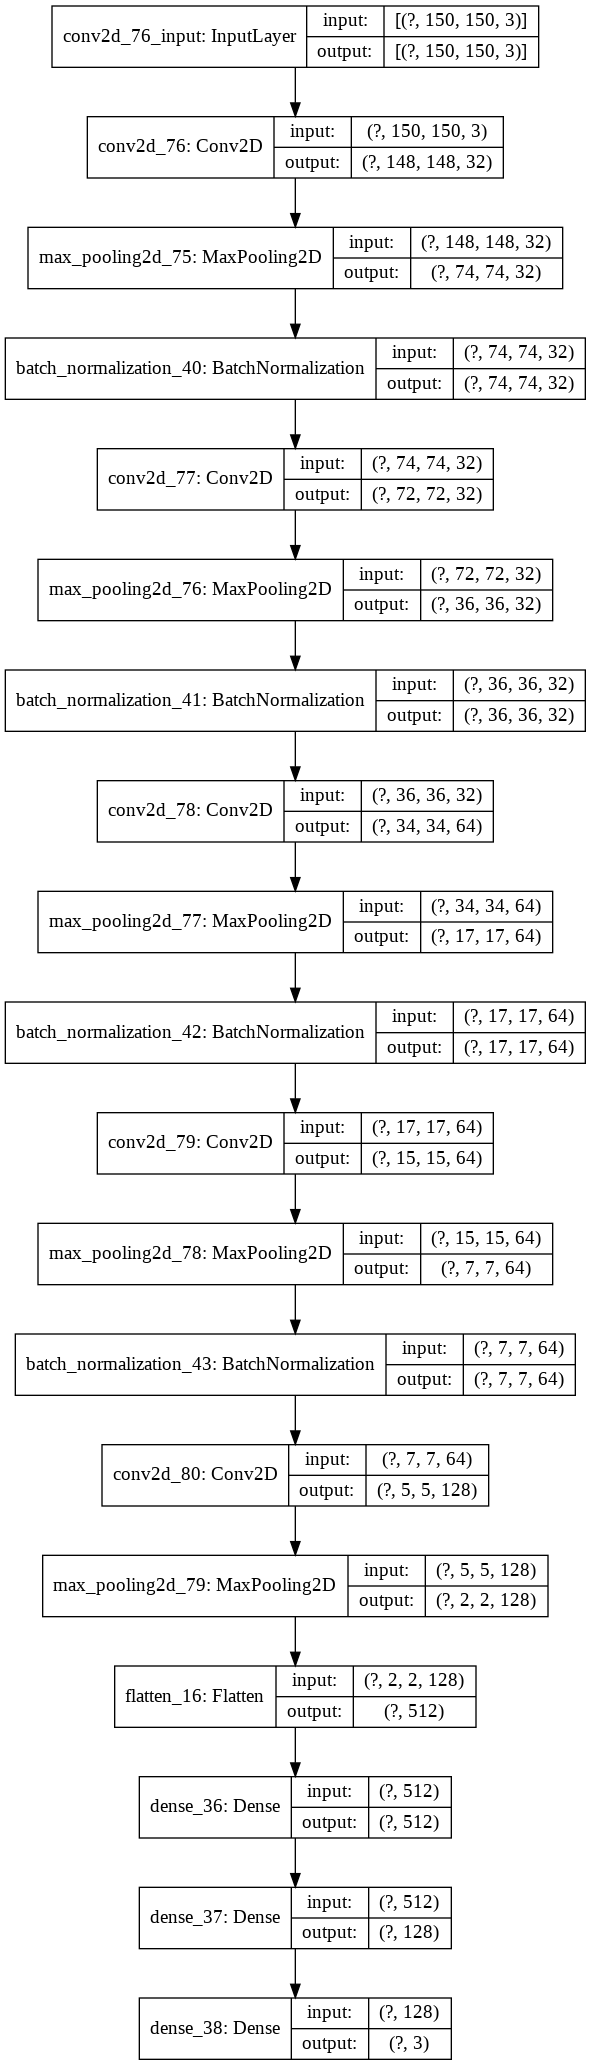

In [77]:
from keras.utils.vis_utils import plot_model

# CNN model
model = tf.keras.models.Sequential([
    # first convolution layer, input is an 150x150 image x3 colors
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.BatchNormalization(),
    # second convolution layer
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    # third convolution layer
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    # fourth convolution layer
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    # fifth convolution layer
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    #tf.keras.layers.MaxPooling2D(2,2),
    # flatten the image pixels
    tf.keras.layers.Flatten(),
    
    # 512 neuron fully connected hidden layer
    #tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
#model1.add()
#tf.keras.layers.Dropout(0.5),
print('Model summary\n')
model.summary()
print('Model architecture\n')
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [16]:
model2 = tf.keras.models.Sequential([
    # first convolution layer, input is an 150x150 image x3 colors
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
   # tf.keras.layers.BatchNormalization(), # new part
    # second convolution layer
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #tf.keras.layers.BatchNormalization(),
    # third convolution layer
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #tf.keras.layers.BatchNormalization(),
    # fourth convolution layer
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    #tf.keras.layers.MaxPooling2D(2,2),
    # flatten the image pixels
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron fully connected hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

# Model compilation and Introducing optimization technique



*   Optimizer: **Adam**(Learning rate = 0.001, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-07 
*   Cost function: Categorical cross entropy
*   metrics : Accuracy



In [17]:
from tensorflow.keras.optimizers import Adam 

model2.compile(optimizer=Adam(learning_rate=0.001),
              loss = 'categorical_crossentropy',
              metrics = ['acc'])

# Epochs

Number of epochs taken = 50 for training


In [18]:
EPOCHS = 50

# Implementing Callbacks

* In the custom callback function **myCallback**, baseline **val_loss** is taken as **0.2800**, after that this custom callback will be executed  to stop the training.

* The best model will be stored inside **best_model.h5** file with the help of **ModelCheckpoint** callback argument, 

In [19]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if(logs.get('val_loss') < 0.2500):
      self.model.stop_training = True

# instance for myCallback
call_stop = myCallback()

#Training the Model

Training is implemented using fit_generator

> *Arguments :*
* **Training data**: train_generator 
* **Validation data**: validation_generator
* **Epochs**: 50
* **Callbacks**: Custom_callback, Model_checkpoint 
* **Verbose**: 1

History of the model training is stored for the analysis.

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early Stopping object
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose=1, patience = 50, baseline = 0.2791)

# ModelCheckpoint object
mc = ModelCheckpoint('best_model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 0)

history = model2.fit_generator(train_generator,
                    epochs=EPOCHS,
                    validation_data = validation_generator,
                    callbacks=[call_stop, mc],
                    verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
750/750 [==============================] - 144s 192ms/step - loss: 0.6177 - acc: 0.6604 - val_loss: 0.4865 - val_acc: 0.7430
Epoch 2/50
750/750 [==============================] - 141s 188ms/step - loss: 0.4561 - acc: 0.7796 - val_loss: 0.3700 - val_acc: 0.8393
Epoch 3/50
750/750 [==============================] - 134s 179ms/step - loss: 0.4160 - acc: 0.8052 - val_loss: 0.3737 - val_acc: 0.8183
Epoch 4/50
750/750 [==============================] - 133s 177ms/step - loss: 0.3974 - acc: 0.8147 - val_loss: 0.3517 - val_acc: 0.8350
Epoch 5/50
750/750 [==============================] - 132s 176ms/step - loss: 0.3867 - acc: 0.8218 - val_loss: 0.3424 - val_acc: 0.8353
Epoch 6/50
750/750 [==============================] - 131s 175ms/step - loss: 0.3785 - acc: 0.8302 - val_loss: 0.3496 - val_acc: 0.8330
Epoch 7/50
750/750 [==============================] - 132s 176ms/step - loss: 0.3708 - acc: 0.8293 - val_los

# Evaluating the model

Checking training accuracy, validation accuracy for evaluation of the trained model

In [87]:
from tensorflow.keras.models import load_model

saved_model = load_model('best_model.h5')
_, train_acc = saved_model.evaluate(train_generator)
_, validation_acc = saved_model.evaluate(validation_generator)
print('Training accuracy: {0}\nValidation accuracy: {1}'.format(train_acc, validation_acc))

94/94 [==============================] - 3s 30ms/step - loss: 0.2699 - acc: 0.8753
Training accuracy: 0.8537499904632568
Validation accuracy: 0.875333309173584


In [85]:
print('Validation output:\n',model.predict_classes(validation_generator))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Validation output:
 [1 1 1 ... 1 1 1]


Visualizing the performance of the training

Text(0.5, 1.0, 'Training and Validation Accuracy')

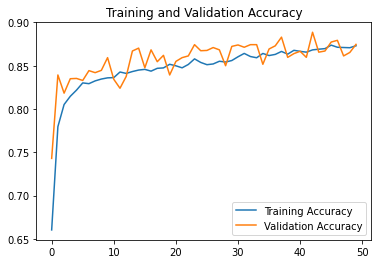

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))  # range for the number of epochs

#plt.figure(figsize=(16, 8))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


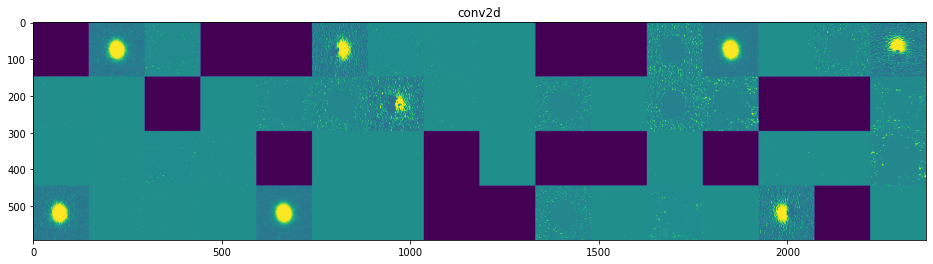

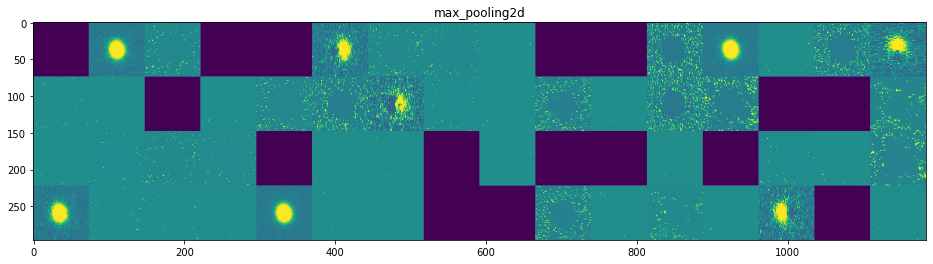

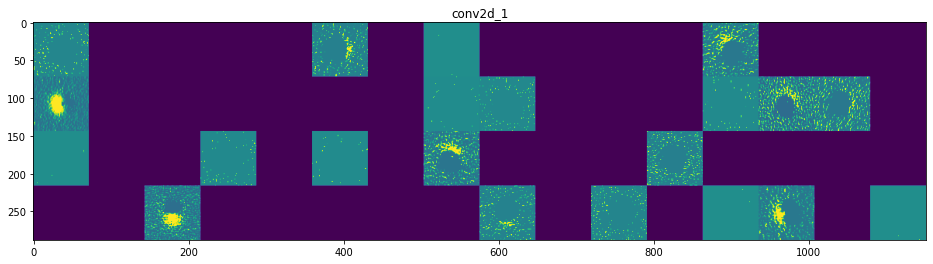

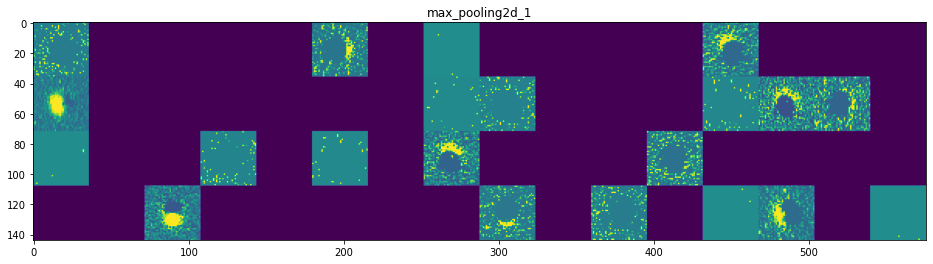

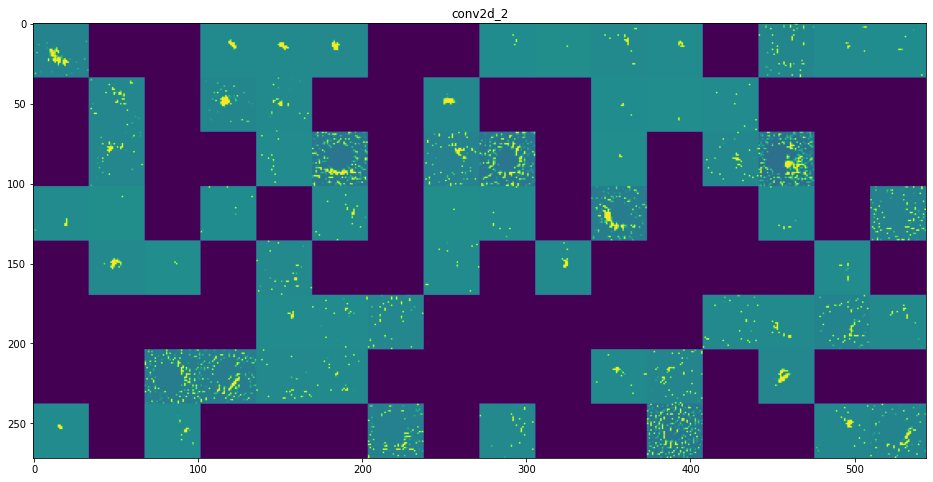

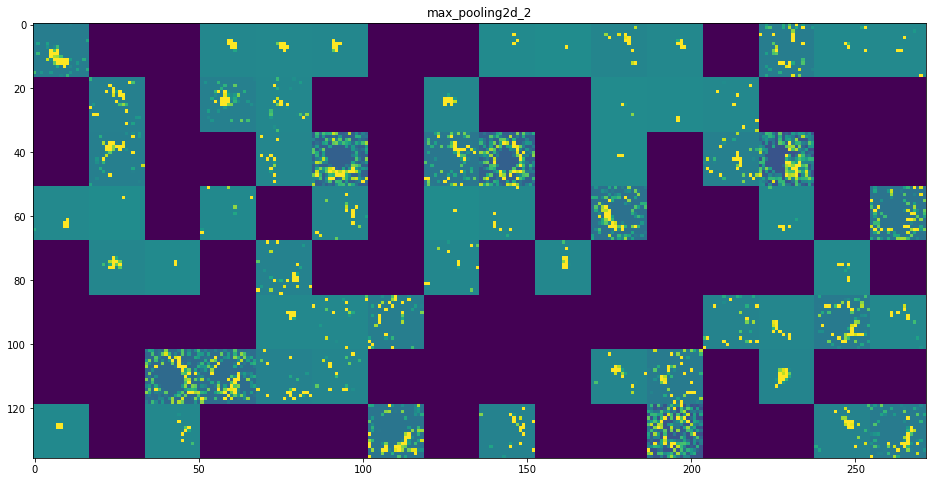

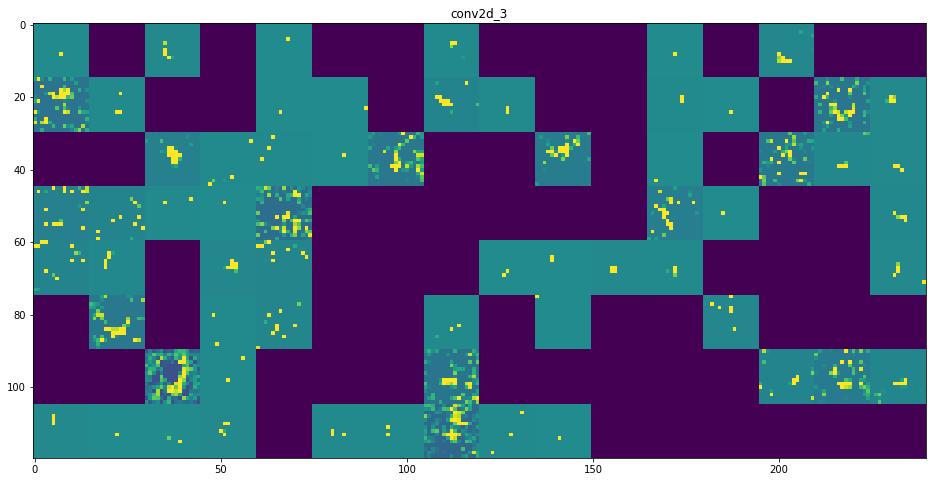

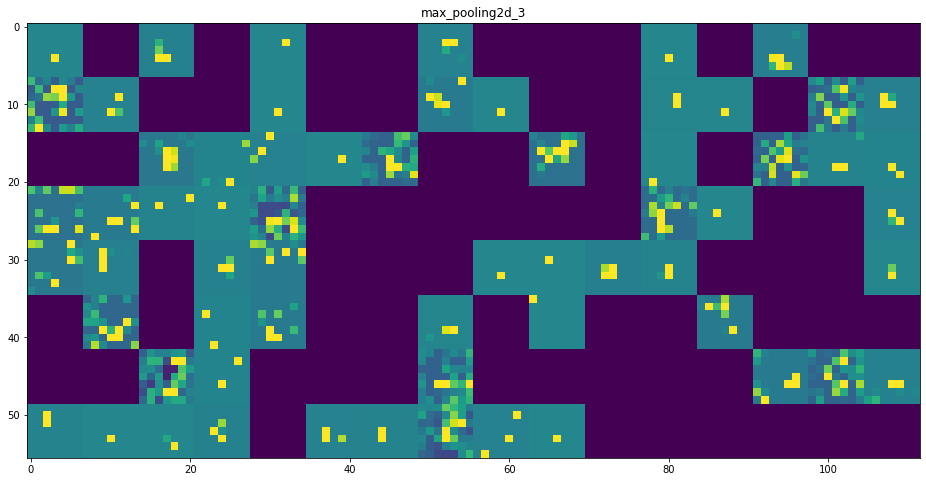

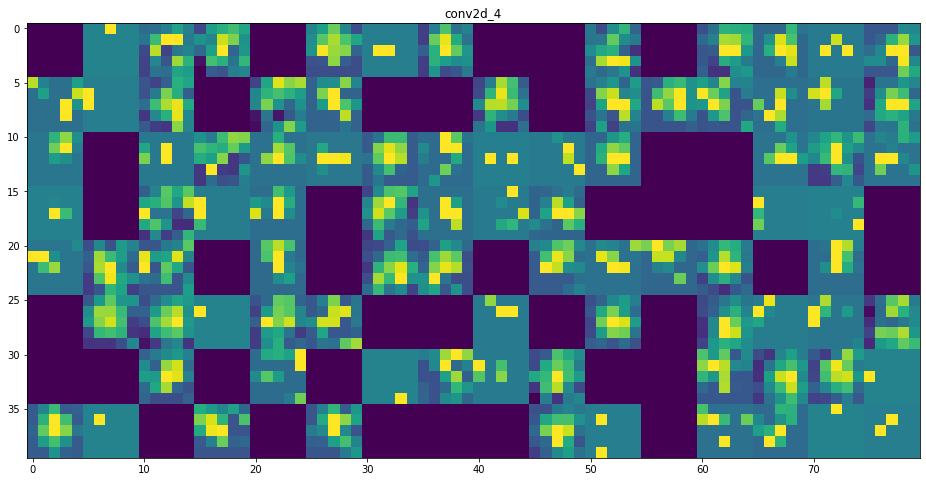

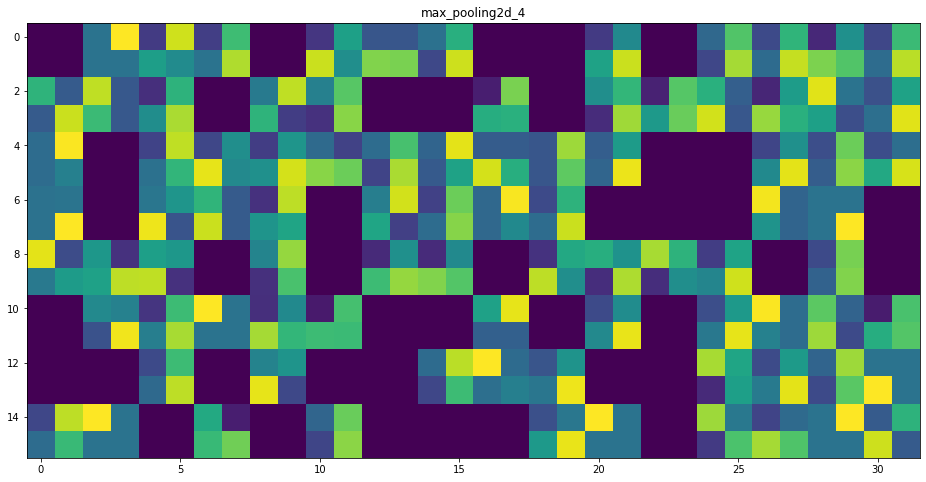

In [23]:
from keras import models
img_path = '/content/Data1/Test/elliptical/elliptical_original_100724.jpg_2e785519-221e-4677-93a2-0f17aa2b58d5.jpg'

layer_outputs = [layer.output for layer in model2.layers[:12]] # Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=model2.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input
img = image.load_img(img_path)
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
activations = activation_model.predict(img_tensor) # Returns a list of five Numpy arrays: one array per layer activation
layer_names = []
for layer in model2.layers[:10]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')